# Classification and Regression Trees (CART) <br><sub>Author: Greg Holste<br></sub>

First let's import modules and define a plotting function for convenience later on.

In [22]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier  # sklearn CART implementation
from CART import *                               # custom CART implementation

def plot_data(X1, X2, Y):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    plot = ax.scatter(X1, X2, c=Y)
    ax.legend(*plot.legend_elements(), loc='lower right', title='$Y$')
    ax.set_xlim(0, 7)
    ax.set_xlabel('$X_1$', fontsize=12)
    ax.set_ylabel('$X_2$', fontsize=12)
    
    return ax

## Motivating Tree-Based Methods

Suppose we have the following data. We have two continuous features $X_1$ and $X_2$ and a discrete output $Y$ with three levels ($0,1,2$).

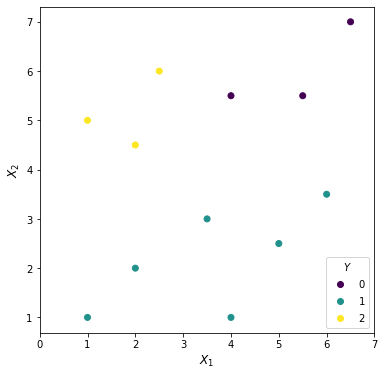

In [23]:
X1 = [1, 2, 5,   6,   3.5, 4,   2,   5.5, 2.5, 6.5, 1,  4]
X2 = [1, 2, 2.5, 3.5, 3,   5.5, 4.5, 5.5, 6,   7,   5,  1]
Y  = [1, 1, 1,   1,   1,   0,   2,   0,   2,   0,   2,  1]

ax = plot_data(X1, X2, Y)

Now if we collect a new observation with $X_1=1$ and $X_2=6$, to what class would you predict it belongs?

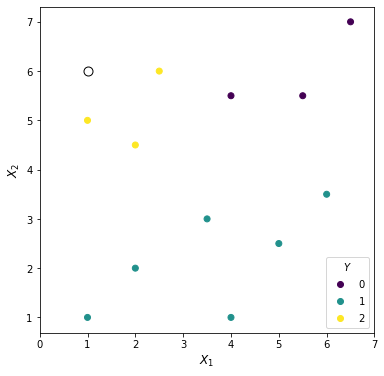

In [26]:
ax = plot_data(X1, X2, Y)
ax.plot(1, 6, fillstyle='none', **dict(color='black', marker='o', markersize=9))
plt.show()

Yellow ($\hat{y}=2$), right? If so, I would argue you probably just implemented a decision tree!
<table align="center">
<tr>
<td> <img src="Figs/toy_data_splits_full.png" alt="Drawing" style="width: 200px;"/> </td>
<td> <img src="Figs/DT_toy_full.png" alt="Drawing" style="width: 600px;"/> </td>
</tr>
</table>

Decision trees split the *feature space* $X_1 \times X_2$ into regions with (orthogonal) binary splits of the form $X_j \leq s$ for some predictor $X_j$ and splitting point $s \in \mathbb{R}$. Splits are made at *decision nodes*, or nonterminal nodes, and predictions are made at *leaf nodes*, or terminal nodes. When a new input falls into terminal node $t$, we simply predict it belongs to the most frequently observed label: $f({\bf x}) =  \arg\!\max_c \hat{p}_{t,c}$.

How do we grow decision trees though? How do we arrive at the "best" split when there is no single obvious choice?

## Background

Assume we have a training set $\mathcal{L} = \{({\bf x_1}, y_1), \dots, ({\bf x_n}, y_n)\}$, where each ${\bf x_i} \in \mathbb{R}^p$ is a $p$-element vector of continuous features/predictors and each $y_i$ is the response/label of interest. When each $y_i$ is continuous, CART will produce a **regression tree**; when each $y_i$ is discrete, CART will produce a **classification tree.** For now, let's focus on this case of a discrete output.

CART-style decision trees are built by recursively making optimal binary splits in the feature space. First, we need to define how we measure the "optimality" of a split. For classification tasks, a common such measure is the **Gini impurity** $$Q_G(t) = \sum_{c=1}^C \hat{p}_{t,c}(1-\hat{p}_{t,c}),$$ where $\hat{p}_{t,c}$ is the proportion of training labels in node $t$ that belong to class $c$. This measures the homogeneity of training labels observed in node $t$. It is called the *impurity* because when only one class appears in node $t$, that node is *perfectly pure* ($Q(t)=0$; we have perfectly separated classes). Conversely, a node $t$ is at its most impure when output classes are represented equally ($Q(t)>0$; we have failed to separate classes).

So how do we use this to find the optimal split at some node $t$? In short, we want to find the predictor $X_j$ (for some $j \in \{1, \dots, p\}$) and splitting point $s \in \mathbb{R}$ that minimize the weighted sum of the impurities resulting from splitting the data at node $t$ via $X_j \leq s$. Let $t_L$ and $t_R$ represent, respectively, the left and right child of node after a split at node $t$, and let $|t|$ represent the number of training examples falling in node $t$. Then the optimal $(j^\star, s^\star)$ pair is given by $$\min_{j,s} \left\{\frac{|t_L|}{|t|}Q(t_L) + \frac{|t_R|}{|t|}Q(t_R)\right\}.$$

We then solve this optimization problem for the left and right children of $t$, and their children, and their children, and so on... until some stopping condition. Ideally, we'd stop when all leaf nodes are perfectly pure, but this is rarely acheivable. Instead we can pre-specify a minimum node size $c$, meaning we ensure $|t| \geq c$ for all nodes $t$ in our tree. We simply add this as a constraint to the above optimization problem as follows: $$\min_{j,s} \left\{\frac{|t_L|}{|t|}Q(t_L) + \frac{|t_R|}{|t|}Q(t_R)\right\} \text{ subject to $|t_L| \geq c$, $|t_R| \geq c$},$$  and we are ready to grow a classification tree! 

## A Simple Application

In `CART.py` we have a from-scratch implementation of CART. Let's fit a classification tree to the toy data presented earlier, and see how we arrive at the decision tree pictured above.

In [27]:
data = pd.DataFrame(dict(X1=X1, X2=X2, Y=Y))
DT = DecisionTree(data, y_type='discrete', min_node_size=1)

Indeed these splits mirror what we see in the decision tree above. The percentages in parentheses are the values of $\hat{p}_{t,\hat{y}}$ for leaf node $t$ and prediction $\hat{y} = \arg\!\max_c \hat{p}_{t,c}$; in words, it is the proportion of label $\hat{y}$ observed in node $t$.

In [7]:
DT.print()

X2 <= 3.5?
--> True:
  Predict 1 (100%)
--> False:
  X1 <= 2.5?
  --> True:
    Predict 2 (100%)
  --> False:
    Predict 0 (100%)


We can compare this with the sci-kit learn `DecisionTreeClassifier` as follows.

In [10]:
sk_DT = DecisionTreeClassifier().fit(pd.DataFrame(dict(X1=X1, X2=X2)), Y)

Sci-kit learn provides a simple function `plot_tree` to plot a decision tree. Note that "entropy" is the same as Gini impurity.

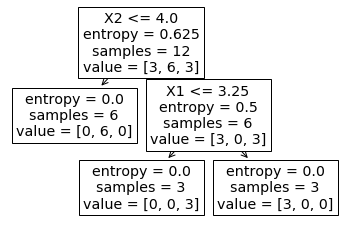

In [36]:
plot_tree(sk_DT, feature_names=['X1', 'X2'])
plt.show()

Interestingly, the two splits made by this tree ($X_2 \leq 4$ and $X_1 \leq 3.25$) are slightly different than the ones chosen by our algorithm. However, observe that they split up the data in *exactly* the same way; these trees are actually equivalent with respect to the training data.

### Comparing Implementations

Note that $X_2=4$ and $X_1=3.25$ do not appear in our training data -- this is the difference between ours and sci-kit learn's CART implementations. When growing the tree, I only consider $(j,s)$ pairs of the form $$\{(j,s)\ |\ j \in \{1, \dots, p\}, s \in \{X_j\}\},$$ where $\{X_j\}$ is simply the set of unique observed levels of $X_j$ in the training set.

We can see this when we turn on the `verbose` option in our implementation, which shows the optimization criterion (and other info) for all splits considered in the tree-growing process.

In [37]:
DecisionTree(data, y_type='discrete', min_node_size=1, verbose=True)

12 samples at this node:
X1 <= 1.0: 0.6 | QL: 0.5, QR: 0.62
X1 <= 2.0: 0.5625 | QL: 0.5, QR: 0.594
X1 <= 2.5: 0.48571 | QL: 0.48, QR: 0.49
X1 <= 3.5: 0.5 | QL: 0.5, QR: 0.5
X1 <= 4.0: 0.5625 | QL: 0.594, QR: 0.5
X1 <= 5.0: 0.53704 | QL: 0.568, QR: 0.444
X1 <= 5.5: 0.6 | QL: 0.62, QR: 0.5
X1 <= 6.0: 0.54545 | QL: 0.595, QR: 0.0
X1 <= 6.5: 0.625 | QL: 0.625, QR: 0.0
X2 <= 1.0: 0.55 | QL: 0.0, QR: 0.66
X2 <= 2.0: 0.5 | QL: 0.0, QR: 0.667
X2 <= 2.5: 0.4375 | QL: 0.0, QR: 0.656
X2 <= 3.0: 0.35714 | QL: 0.0, QR: 0.612
X2 <= 3.5: 0.25 | QL: 0.0, QR: 0.5
X2 <= 4.5: 0.34286 | QL: 0.245, QR: 0.48
X2 <= 5.0: 0.375 | QL: 0.375, QR: 0.375
X2 <= 5.5: 0.55 | QL: 0.56, QR: 0.5
X2 <= 6.0: 0.54545 | QL: 0.595, QR: 0.0
X2 <= 7.0: 0.625 | QL: 0.625, QR: 0.0
6 samples at this node:
X1 <= 1.0: 0.0 | QL: 0.0, QR: 0.0
X1 <= 2.0: 0.0 | QL: 0.0, QR: 0.0
X1 <= 3.5: 0.0 | QL: 0.0, QR: 0.0
X1 <= 4.0: 0.0 | QL: 0.0, QR: 0.0
X1 <= 5.0: 0.0 | QL: 0.0, QR: 0.0
X1 <= 6.0: 0.0 | QL: 0.0, QR: 0.0
X2 <= 1.0: 0.0 | QL: 0.0

Here, all splitting points tested can be found in the data, and we can verify that indeed $X_2 \leq 3.5$ provides the best first split (smallest optimization criterion of $0.25$) and $X_1 \leq 2.5$ provides the best second (final) split (smallest criterion of $0$).

## Closing Remarks

I'm taking the simpler (naive) approach of only querying splitting points $s$ that were observed in the data; sci-kit learn is likely randomly sampling reasonable splitting points (which are not necessarily observed). While my approach explores all *unique* splits exactly once, it is naive because this exhaustive search becomes computationally infeasible with larger $n$ or $p$.

CART can also – as the name suggest – be used for regression when the output is continuous. To grow a regression tree, we simply (1) swap out our impurity measure for something like mean-squared error (often called a "loss" or "cost" function) and (2) change how we make predictions at leaf nodes.

First let $m = \frac{1}{|t|} \sum_{i: {\bf x_i} \in t} y_i$ be the mean reponse for all training samples falling in node $t$. Then we can define the mean-squared error loss $$L(t) = \frac{1}{|t|} \sum_{i: {\bf x_i} \in t} (y_i - m)^2$$ and proceed with the tree-growing process simply swapping out $Q(t)$ for $L(t)$ to accomodate our continuous response variable. Except, our final prediction at terminal node $t$ is no longer the most frequent response; instead, it is now the mean response $\hat{f}({\bf x}) = m$.

There is much more to CART and tree-based methods, but these are the basics. In the next notebook, we'll tackle boosting, a powerful technique to ensemble many trees.